In [1]:
using Distributions
using Random
using scBayesDeconv
using Plots
using DataFrames
using CSV

# Distributions 1D

## Noise distributions

In [2]:
dNoise = Dict()

dNoise["Normal"] = Normal(0,1)
dNoise["SkewNormal"] = SkewNormal(-1.32,1.65,7)
# dNoise["BimodalAsym"] = MixtureModel([
#                         Normal(-0.82-0.16,0.41),
#                         Normal(0.82-0.16,0.71),
#                         ],[.4,.6])
# dNoise["BimodalSym"] = MixtureModel([
#                         Normal(-0.9,0.5),
#                         Normal(0.9,0.5),
#                         ],[.5,.5])
# dNoise["TrimodalAsym"] = MixtureModel([
#                         Normal(-1.7+.08,0.65),
#                         Normal(0+.08,0.35),
#                         Normal(1.3+.08,0.35),
#                         ],[.2,.6,.2])
# dNoise["TrimodalSym"] = MixtureModel([
#                         Normal(-1.3,0.65),
#                         Normal(0,0.15),
#                         Normal(1.3,0.65),
#                         ],[.25,.5,.25])
dNoise["Student"] = TDist(3) 
# dNoise["Binomial"] = MixtureModel(
#     Normal[
#         Normal(-2,1),
#         Normal(6,1)
#     ],
#     [.5,.5]
#     )
# dNoise["Laplace"] = Laplace(0,.72) 
# dNoise["LaplaceSharp"] = MixtureModel([
#                         Laplace(0.,0.2),
#                         Laplace(0.,0.1),
#                         ],[.5,.5]);

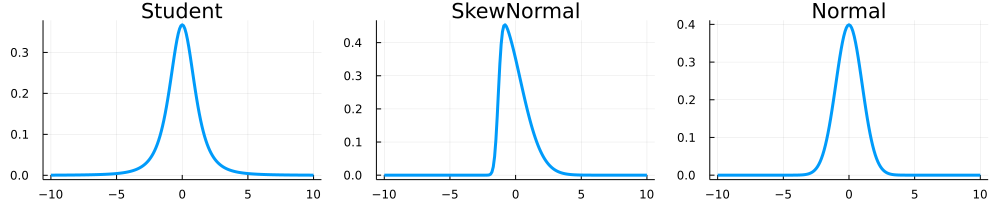

In [3]:
x = -10:.1:10

l = []
for (i,j) in pairs(dNoise)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(1,3),size=[1000,200])

## Target distributions

In [4]:
dTarget = Dict()

dTarget["BimodalAsym"] = MixtureModel([
                        Normal(-.43,0.6),
                        Normal(1.67,0.6),
                        ],[.8,.2])
dTarget["BimodalSym"] = MixtureModel([
                        Normal(-0.9,0.5),
                        Normal(0.9,0.5),
                        ],[.5,.5])
dTarget["SkewNormal"] = SkewNormal(-1.32,1.65,7)


SkewNormal{Float64}(ξ=-1.32, ω=1.65, α=7.0)

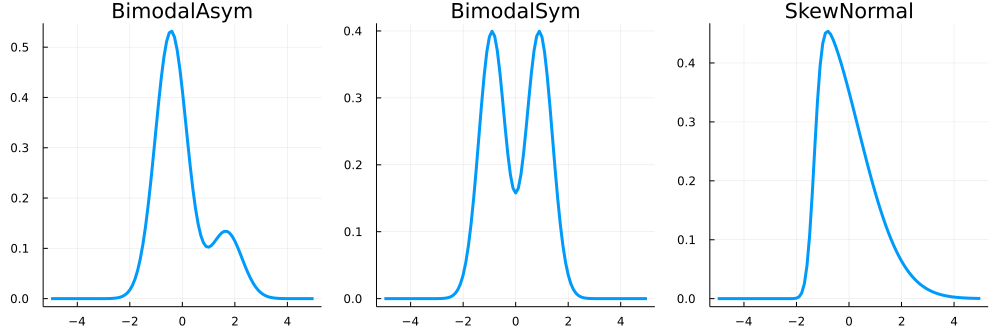

In [5]:
x = -5:.1:5

l = []
for (i,j) in pairs(dTarget)
    push!(l,plot(x,pdf.(j,x),title=i,linewidth=3,label=""))
end

plot(l...,layout=(1,3),size=[1000,330])

## Convolved distributions

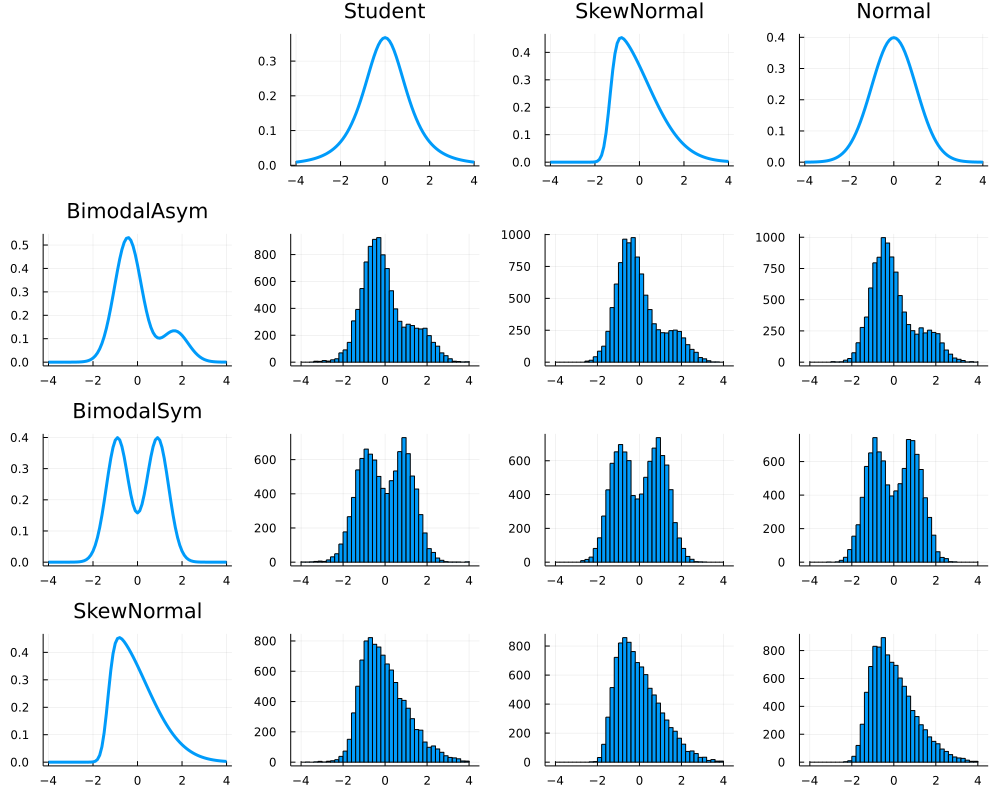

In [6]:
x = -4:.1:4
bins=-4:.2:4
plots = []
snr=4

push!(plots,plot(ticks=nothing,axis=false))
for (i,dn) in pairs(dNoise)

    push!(plots,plot(x,pdf.(dn,x),title=i,linewidth=3,label=""))

end

for (j,dt) in pairs(dTarget)

    push!(plots,plot(x,pdf.(dt,x),title=j,linewidth=3,label=""))

    for (i,dn) in pairs(dNoise)

        data = rand(dn,10000)/snr+rand(dt,10000)
        push!(plots,histogram(data,bins=bins,label=""))

    end

end


plot(plots...,layout=(4,4),size=(1000,800))

## Sample deconvolution

In [7]:
N = 100
snr = 2
dn = dNoise["Normal"]
dt = dTarget["BimodalAsym"]

noise = rand(dn,N)/snr
target = rand(dt,N)
convolution = rand(dn,N)/snr+rand(dt,N);

In [8]:
yNewmann,xNewmann = newmannDeconvolution(noise,convolution);

In [9]:
dnfitted = infiniteGaussianMixture(reshape(noise,length(noise),1))
dtfitted = infiniteGaussianMixtureDeconvolution(reshape(convolution,length(convolution),1),dnfitted);

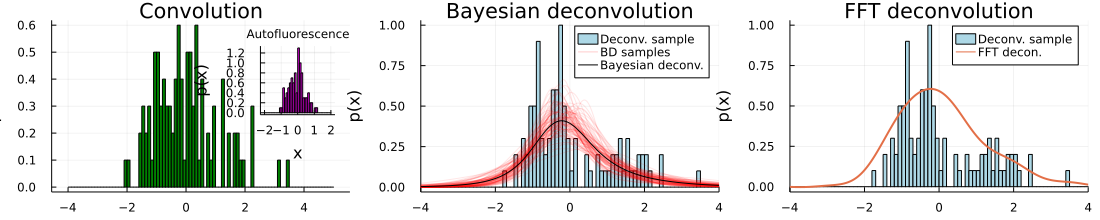

In [10]:
p1 = histogram(convolution,bins=-4:.1:5,title="Convolution",label="",normalize=true,color="green",ylabel="p(x)",xlabel="x")
histogram!(noise,bins=-2:0.1:2,inset=(1,bbox(.7,.15,.25,.4)),subplot=2,bg_inside=nothing,label="",normalize=true,title="Autofluorescence",titlefontsize=8,color="magenta",ylabel="p(x)",xlabel="x")

p2 = histogram(target,bins=-4:.1:4,title="Bayesian deconvolution",normalize=true,color="lightblue",ylabel="p(x)",xlabel="x",label="Deconv. sample")
x = -4:.01:4
y = zeros(100,length(x))
plot!(p2,x,pdf(dtfitted.samples[2],reshape(x,1,length(x))),color="red",alpha=0.2,label="BD samples")
for i in 2:100
    plot!(p2,x,pdf(dtfitted.samples[i],reshape(x,1,length(x))),label="",color="red",alpha=0.1)
    y[i,:] = pdf(dtfitted.samples[i],reshape(x,1,length(x)))[:,1]
end
plot!(p2,x,mean(y,dims=1)[1,:],label="Bayesian deconv.",color="black",legendfontsize=8)
xlims!(-4,4)

p3 = histogram(target,bins=-4:.1:4,title="FFT deconvolution",normalize=true,color="lightblue",ylabel="p(x)",xlabel="x",label="Deconv. sample")
plot!(p3,xNewmann,yNewmann,linewidth=2,label="FFT decon.")
xlims!(-4,4)

plot(p1,p2,p3,layout=(1,3),size=[1100,220])

In [11]:
f(x) = pdf(dt,x[1])
mios = scBayesDeconv.metrics.mio(dtfitted,f)

println("Bayesian MIO: ",round(mean(mios),digits=2),"±",round(std(mios),digits=2))

mioNewmann(x,y,dt) = 1-sum(abs.(pdf.(dt,x).-y)*(x[2]-x[1]))/2
println("FFT MIO: ",round(mioNewmann(xNewmann,yNewmann),digits=2))

Bayesian MIO: 0.81±0.06


MethodError: MethodError: no method matching mioNewmann(::StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, ::Vector{Float64})
Closest candidates are:
  mioNewmann(::Any, ::Any, !Matched::Any) at /home/gabriel/Documents/Acadèmic/PhD/Projects_link/scBayesDeconv.jl/examples/artificialDeconvolutions.ipynb:6

## Deconvolutions

In [19]:
x = -10:.1:10

resultsNoise = 0
try
    resultsNoise = CSV.read("Noise.csv",DataFrame)
catch
    resultsNoise = DataFrame()
end

resultsDeconvolution = 0
try
    resultsDeconvolution = CSV.read("Deconvolution.csv",DataFrame)
catch
    resultsDeconvolution = DataFrame()
end

for N in [100,1000]
    for snr in [10,1]
        for (i,dn) in pairs(dNoise)

            n = reshape(rand(dn,N)/snr,N,1)
            fitNoise = infiniteGaussianMixture(n,κ0=0.001,k=1)

            if snr == 1
                fn(x) = pdf(dn,x[1])
                mios = scBayesDeconv.metrics.mio(fitNoise,fn)

                append!(resultsNoise,
                    ["Noise"=>i[1:min(7,length(i))],"Ratio"=>snr,"Size"=>N,"MIO mean"=>round(mean(mios),digits=4),"MIO std"=>round(std(mios),digits=4)]
                )
                CSV.write("Noise.csv", string.(resultsNoise))
            end

            for (j,dt) in pairs(dTarget)

                if size(resultsDeconvolution[(resultsDeconvolution[!,"Size"].==N) .& 
                                                (resultsDeconvolution[!,"Ratio"].==snr) .& 
                                                (resultsDeconvolution[!,"Noise"].==i) .& 
                                                (resultsDeconvolution[!,"Target"].==j),:])[1] == 0

                    t = reshape(rand(dt,N),N,1)
                    c = reshape(rand(dn,N)/snr.+rand(dt,N),N,1)
                    
                    ft(x) = pdf(dt,x[1])

                    fitDeconvolution = infiniteGaussianMixtureDeconvolution(c,fitNoise,k=1)
                    mios = scBayesDeconv.metrics.mio(fitDeconvolution,ft)

                    fitConvolution = infiniteGaussianMixture(c,k=1)
                    miosConvolution = scBayesDeconv.metrics.mio(fitConvolution,ft)

                    yNewmann, xNewmann = newmannDeconvolution(n,c)
                    mionewman = mioNewmann(xNewmann,yNewmann,dt)

                    append!(resultsDeconvolution,
                        ["Noise"=>i,"Target"=>j,"Ratio"=>snr,"Size"=>N,"MIO mean"=>round(mean(mios),digits=4),"MIO std"=>round(std(mios),digits=4),
                        "MIO Convolution mean"=>round(mean(miosConvolution),digits=4),"MIO Convolution std"=>round(std(miosConvolution),digits=4),"MIO Newmann"=>round(mionewman,digits=4)]
                    )
                    CSV.write("Deconvolution.csv", string.(resultsDeconvolution))

                end

            end

        end
    end
end

In [13]:
p1 = plot([0,1],[0,1],color="black",label="")
color = [Dict([100=>"lightblue",1000=>"orange",10000=>"green"])[i] for i in resultsDeconvolution[!,"Size"]]
style = [Dict([10=>:square,1=>:cross])[i] for i in resultsDeconvolution[!,"Ratio"]]
scatter!(p1,resultsDeconvolution[!,"MIO mean"],resultsDeconvolution[!,"MIO Newmann"],color=color,markershape=style,xlabel="MIO Bayesian Deconvolution",ylabel="MIO FFT Deconvolution",label="")
xlims!(0,1)
ylims!(0,1)

plot(p1, size=(500,500))

UndefVarError: UndefVarError: resultsDeconvolution not defined

In [14]:
p1 = plot([0,1],[0,1],color="black",label="")
color = [Dict([100=>"lightblue",1000=>"orange",10000=>"green"])[i] for i in resultsDeconvolution[!,"Size"]]
style = [Dict([10=>:square,1=>:cross])[i] for i in resultsDeconvolution[!,"Ratio"]]
scatter!(p1,resultsDeconvolution[!,"MIO mean"],resultsDeconvolution[!,"MIO Convolution mean"],color=color,markershape=style,xlabel="MIO Bayesian Deconvolution",ylabel="MIO Bayesian Convolution",label="")
xlims!(0,1)
ylims!(0,1)

plot(p1, size=(500,500))

UndefVarError: UndefVarError: resultsDeconvolution not defined

In [15]:
p1 = plot([0,1],[0,1],color="black",label="")
color = [Dict([100=>"lightblue",1000=>"orange",10000=>"green"])[i] for i in resultsDeconvolution[!,"Size"]]
style = [Dict([10=>:square,1=>:cross])[i] for i in resultsDeconvolution[!,"Ratio"]]
scatter!(p1,resultsDeconvolution[!,"MIO Newmann"],resultsDeconvolution[!,"MIO Convolution mean"],color=color,markershape=style,xlabel="MIO FFT Deconvolution",ylabel="MIO Bayesian Convolution",label="")
xlims!(0,1)
ylims!(0,1)

plot(p1, size=(500,500))

UndefVarError: UndefVarError: resultsDeconvolution not defined